In [1]:
import pandas as pd
import numpy as np
from scipy import linalg
from scipy.stats import multivariate_normal as mvn
import time
import itertools
from tqdm import tqdm, tqdm_notebook
from collections import Counter
tqdm_notebook().pandas()

from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors.kde import KernelDensity
from sklearn import mixture
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering

from nltk.stem import PorterStemmer
# from nltk.corpus import stopwords
# import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

In [2]:
dfb0 = pd.read_pickle('data/MontrealBusiness.pkl.gz')

# Clustering

In [17]:
class ClusteringClass:
    def __init__(self,dfb0):
        self.dfb0 = dfb0
        self.Xf = np.array(self.dfb0[['longitude','latitude']])
        
        kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(self.Xf)
        self.scrs = kde.score_samples(self.Xf)
        self.dfb0['scr_0'] = self.scrs
        
        self.color_iter = itertools.cycle(['plum','peachpuff','lightsalmon', 'cyan', 'cornflowerblue', 'gold',
                              'darkorange', 'lightcoral','yellowgreen',
                              'lightgreen','dodgerblue','green'])
        
        self.street_map = gpd.read_file('geodata/montreal_road_network/montreal_road_network.shp')
        
    def exclude_outliers(self,Radius):
        self.X = self.Xf[self.scrs >= Radius,:]
        X1 = self.Xf[self.scrs < Radius,:]
        plt.scatter(self.X[:,0],self.X[:,1], alpha = 0.05)
        plt.scatter(X1[:,0],X1[:,1], alpha = 0.05, color = 'red')
        plt.title('Outliers')

        self.dfb = self.dfb0[self.dfb0.scr_0 >= Radius].copy()

    
    def get_patch(self, ax, mean, covar, color):
        v, w = linalg.eigh(covar)
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])
        
        angle = np.arctan(u[1] / u[0])
        angle = 180. * angle / np.pi  # convert to degrees
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.4)
        
        return ell
    
    def plot_clusters(self, title='Clusters', streets=True, print_id=True, print_data=True):
        fig, ax = plt.subplots(figsize=(12,12))
        if streets:
            self.street_map.plot(ax = ax, alpha = 0.4, color = 'grey')
        for i, (mean, covar, color) in enumerate(zip(self.means_, self.covariances_, self.color_iter)):
            self.dfc.loc[i,'color'] = color
            if not np.any(self.Y_ == i):
                continue 
            if print_data:
                ax.scatter(self.X[self.Y_ == i, 0], self.X[self.Y_ == i, 1], 5, color=color, alpha = 0.4)
            if print_id:
                ax.text(mean[0],mean[1], str(i), clip_on=True ,fontsize=18, fontweight='bold' )

            ax.add_artist(self.get_patch(ax, mean, covar, color))
            plt.title(title, fontsize=20)
            
    def cluster_gaussians(self):
        self.means_ = np.zeros([self.N_clusters,2])
        self.covariances_ = np.zeros([self.N_clusters,2,2])
        for i in range(self.N_clusters):
            Xi = self.X[self.Y_ == i, :]
            self.means_[i,:] = [np.mean(Xi[:,0]),np.mean(Xi[:,1])]
            self.covariances_[i,:,:]  = np.cov(np.transpose(Xi))
            
    def gmm_(self, N_clusters = 60):
        self.N_clusters = N_clusters
        self.model = mixture.GaussianMixture(n_components=N_clusters, covariance_type='full')
        self.model.fit(self.X)
        self.Y_ = self.model.predict(self.X)
        self.means_ = self.model.means_
        self.covariances_ = self.model.covariances_
        self.create_clusters_dataframe()
    
    def bgmm_(self, N_clusters = 60):
        self.N_clusters = N_clusters
        self.model = mixture.BayesianGaussianMixture(n_components=N_clusters, covariance_type='full', 
                                      weight_concentration_prior = 1, n_init = 5, max_iter = 1000, tol = 1e-3)
        self.model.fit(self.X)
        self.Y_ = self.model.predict(self.X)
        self.means_ = self.model.means_
        self.covariances_ = self.model.covariances_
        self.create_clusters_dataframe()
    
    def kmeans_(self, N_clusters = 60, plot_=True):
        self.N_clusters = N_clusters
        self.model = KMeans(n_clusters=N_clusters, random_state=0).fit(self.X)
        self.Y_ = self.model.predict(self.X)
        self.cluster_gaussians()
        self.create_clusters_dataframe()
    
    def agglo_(self, N_clusters = 60, plot_=True):
        self.N_clusters = N_clusters
        self.Y_ = AgglomerativeClustering(n_clusters=N_clusters).fit_predict(self.X)
        self.cluster_gaussians()
        self.create_clusters_dataframe()
            
    def create_clusters_dataframe(self):
        self.dfc = pd.DataFrame(columns=['mean','covar'])
        for i in range(self.N_clusters):
            self.dfc.loc[i,'mean']  = self.means_[i,:]
            self.dfc.loc[i,'covar'] = self.covariances_[i,:,:]

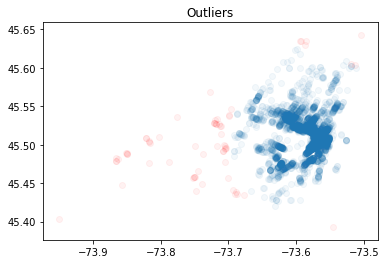

In [18]:
cls = ClusteringClass(dfb0)
cls.exclude_outliers(1.2)

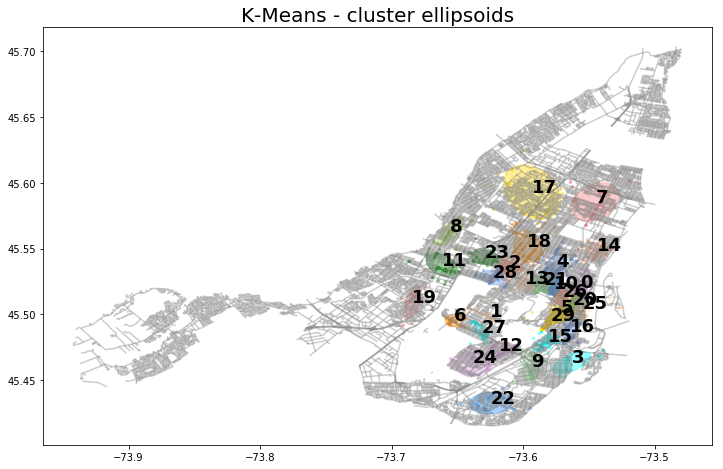

In [19]:
cls.kmeans_(N_clusters=30)
cls.plot_clusters(title = 'K-Means - cluster ellipsoids')

# Recommendations

In [6]:
# Yelp data
dfb  = cls.dfb
dfr = pd.read_pickle('data/MontrealReview.pkl.gz')
# Airbnb data
dfal = pd.read_pickle('data/MontrealAirbnbListings.pkl.gz')

In [7]:
tfidf  = joblib.load('models/TFIDF_model.joblib')
# svd    = joblib.load('models/SVD_model.joblib')
logreg = joblib.load('models/LogReg_model_noSVD.joblib')

In [8]:
# est_sent = logreg.predict(svd.transform(tfidf.transform(dfr['stemmed_text'])))
est_sent = logreg.predict(tfidf.transform(dfr['stemmed_text']))
dfr['est_sentiment'] = est_sent
den = len(dfr)
dfr = dfr[dfr['est_sentiment'] == 1]
enum = len(dfr)
print('{:.1f}% of Yelp reviews in Montreal are positive'.format( enum/den*100 ) ) 

75.5% of Yelp reviews in Montreal are positive


In [50]:
class RecommendationsClass:
    def __init__(self,dfb,dfr,dfal):
        self.dfal = dfal
        self.dfc = cls.dfc
        
        predict_cluster = lambda x: cls.model.predict(np.array([[x.longitude,x.latitude]]))[0]
        sum_text        = lambda x: '%s' % ' '.join(x)
        
        def cluster_location_score(row):
            xy = [row.longitude,row.latitude]
            mean  = self.dfc.loc[row.cluster,'mean']
            covar = self.dfc.loc[row.cluster,'covar']
            return mvn.pdf(xy,mean,covar)/mvn.pdf(mean,mean,covar)
        
        def nbrhood_freq(row):
            D = row.counter
            sm = sum(D.values())           
            return {x:[y/sm,y] for x, y in D.items() if y/sm > 0.1} 
        
        def neghborhood_dataframe(dfcn,dfal2):
            dfcn['cluster'] = dfcn.index
            dfn = pd.DataFrame(columns=['cluster','neighborhood','membership','#listings','color'])
            for i in dfcn.index:
                cl = dfcn.cluster[i]
                co = dfcn.color[i]
                D = sorted(dfcn.neighborhoods[i].items(), key=lambda kv: kv[1][0], reverse=True)
                for (n, f) in D:
                    avp = dfal2[(dfal2['cluster'] == cl) & (dfal2['neighbourhood_cleansed'] == n)].price_float.mean()
                    row = {'cluster':cl,'neighborhood':n,'membership':'{:.0f}%'.format(f[0]*100),
                           '#listings':int(f[1]),'average price':'${:.2f}'.format(avp),'color':co}
                    dfn = dfn.append(row,ignore_index=True)
            return dfn
            
        # Yelp
        self.tfidf_yelp = TfidfVectorizer(max_features=10000)
        self.tfidf_yelp.fit(list(dfr.stemmed_text))
        dfb['cluster']  = dfb.apply(predict_cluster, axis=1)
        dfb_tmp = dfr.groupby('business_id')['stemmed_text'].apply(sum_text).to_frame(name='text_yelp')
        dfb = dfb.merge(dfb_tmp, how='inner', on='business_id')
        dfcy = dfb.groupby('cluster')['text_yelp'].apply(sum_text).to_frame(name='text_yelp')
        del dfb_tmp
        
        # Airbnb
        dfal2 = dfal[ dfal['stemmed_neighborhood_overview'].notnull() ].copy()
        self.tfidf_airbnb = TfidfVectorizer(max_features=10000)
        self.tfidf_airbnb.fit(list(dfal2.stemmed_neighborhood_overview))
        dfal2['cluster'] = dfal2.apply(predict_cluster, axis=1)
        dfca = dfal2.groupby('cluster')['stemmed_neighborhood_overview'].apply(sum_text).to_frame(name='text_airbnb')
 
        # Merge Yelp-Airbnb and vectorize 
        dfc_tmp = dfcy.merge(dfca, how='outer', on='cluster')
        dfc_tmp['vec_yelp']   = dfc_tmp.apply(lambda x: self.tfidf_yelp.transform([x.text_yelp]), axis = 1)
        dfc_tmp['vec_airbnb'] = dfc_tmp.apply(lambda x: self.tfidf_airbnb.transform([x.text_airbnb]), axis = 1)
        dfc_tmp = dfc_tmp.drop(columns=['text_yelp','text_airbnb'])
        
        self.dfc = self.dfc.merge(dfc_tmp, how='outer', left_index=True, right_on='cluster')
        del dfc_tmp, dfcy, dfca
        
        # Neighborhood data
        dfal2['cluster_score'] = dfal2.apply(cluster_location_score, axis=1)
        dfal3 = dfal2[dfal2['cluster_score'] > 0.01]
        dfcn = dfal3.groupby('cluster').apply(lambda x: Counter(x.neighbourhood_cleansed)).to_frame(name='counter')
        dfcn['neighborhoods'] = dfcn.apply(nbrhood_freq,axis = 1)
        dfcn['color'] = self.dfc.color
        
        self.dfn = neghborhood_dataframe(dfcn,dfal2)
        del dfal2, dfal3, dfcn
        
    def keywords(self, kws):                      
        ps = PorterStemmer()
        kws = ' '.join(list(set([ps.stem(kw) for kw in kws])))
        
        # Vectorization of keywords
        kws_vec_yelp   = self.tfidf_yelp.transform([kws])
        kws_vec_airbnb = self.tfidf_airbnb.transform([kws])
        # Cosine similarity between cluster vector and keywords for Yelp and Airbnb
        self.cs_yelp   = lambda x: cosine_similarity(x.vec_yelp,kws_vec_yelp)[0][0]
        self.cs_airbnb = lambda x: cosine_similarity(x.vec_airbnb,kws_vec_airbnb)[0][0] 
        self.dfc['score_yelp']   = self.dfc.apply(self.cs_yelp, axis=1)
        self.dfc['score_airbnb'] = self.dfc.apply(self.cs_airbnb, axis=1)
        # Normalization
        self.dfc['score_yelp']   = self.dfc['score_yelp']/self.dfc['score_yelp'].sum()
        self.dfc['score_airbnb'] = self.dfc['score_airbnb']/self.dfc['score_airbnb'].sum()
        # Addition of Yelp and Airbnb scores and re-normalization
        self.dfc['kws_score'] = self.dfc['score_yelp'] + self.dfc['score_airbnb']
        self.dfc['kws_score'] = self.dfc['kws_score']/self.dfc['kws_score'].sum()
        # Maintain top 5 clusters/nieghborhoods
        self.dfc_ = self.dfc.nlargest(5, 'kws_score')
        self.dfc_['max_pdf'] = self.dfc_.apply(lambda x: mvn.pdf(x['mean'],x['mean'],x['covar']),axis=1)

    def recommendation_score(self,row):
        xy = [row.longitude,row.latitude]
        score = 0
        for i in self.dfc_.index:
            mean  = self.dfc_.loc[i,'mean']
            covar = self.dfc_.loc[i,'covar']
            score += self.dfc_.kws_score[i]*mvn.pdf(xy,mean,covar)/self.dfc_.loc[i,'max_pdf']
        return score
    
    def recommend(self, N_recommendations=20, Max_budget=1e10, Room_type='Entire home/apt'):
        dfar = self.dfal[(self.dfal.room_type == Room_type) & (self.dfal.price_float <= Max_budget)].copy()
        dfar['rec_score'] = dfar.apply(self.recommendation_score, axis = 1)
        top_n = dfar.nlargest(N_recommendations, 'rec_score')
        return top_n

In [51]:
rec = RecommendationsClass(dfb,dfr,dfal)
rel_cls = []

In [66]:
# Example 1
rec.keywords(['hipster','hipsters','hippie','hippy','art','arty','artistic','artists','artist'])
topN_1 = rec.recommend(N_recommendations=20, Max_budget=35., Room_type='Entire home/apt')
dfc1 = rec.dfc.copy()

In [67]:
# Example 2
rec.keywords(['hipster','hipsters','hippie','hippy','art','arty','artistic','artists','artist'])
topN_2 = rec.recommend(N_recommendations=20, Max_budget=70., Room_type='Entire home/apt')
rel_cls += list(rec.dfc_.index)
rec.dfc_['kws_score']

cluster
13    0.103190
26    0.083418
20    0.080391
21    0.065682
29    0.063937
Name: kws_score, dtype: float64

In [68]:
# Example 3
rec.keywords(['clubs','nightlife','music'])
topN_3 = rec.recommend(N_recommendations=20, Max_budget=35., Room_type='Entire home/apt')
dfc2 = rec.dfc.copy()

In [69]:
# Example 4
rec.keywords(['clubs','nightlife','music'])
topN_4 = rec.recommend(N_recommendations=20, Max_budget=70., Room_type='Entire home/apt')
rel_cls += list(rec.dfc_.index)
rec.dfc_['kws_score']

cluster
29    0.092629
5     0.087529
26    0.081562
0     0.074379
25    0.070374
Name: kws_score, dtype: float64

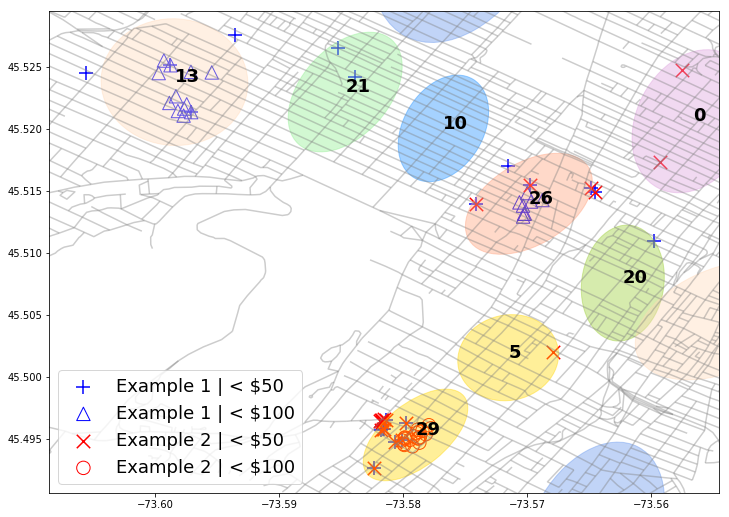

In [70]:
cls.plot_clusters(title=None, print_id=True, print_data=False)
labs =  ['Example 1 | < $50','Example 1 | < $100']
labs += ['Example 2 | < $50','Example 2 | < $100']
plt.scatter(topN_1.longitude,topN_1.latitude, 180, marker='+', facecolors='b', edgecolors='b', label=labs[0])
plt.scatter(topN_2.longitude,topN_2.latitude, 180, marker='^', facecolors='none', edgecolors='b', label=labs[1])
plt.scatter(topN_3.longitude,topN_3.latitude, 180, marker='x', facecolors='r', edgecolors='r', label=labs[2])
plt.scatter(topN_4.longitude,topN_4.latitude, 180, marker='o', facecolors='none', edgecolors='r', label=labs[3])
xlist = list(topN_1.longitude)+list(topN_2.longitude)+list(topN_3.longitude)+list(topN_4.longitude)
ylist = list(topN_1.latitude)+list(topN_2.latitude)+list(topN_3.latitude)+list(topN_4.latitude)
xlims = [min(xlist)-0.003,max(xlist)+0.003]
ylims = [min(ylist)-0.002,max(ylist)+0.002]
plt.xlim(xlims)
plt.ylim(ylims)
plt.legend(fontsize=18)
plt.savefig('montreal.png', dpi=600, bbox_inches='tight')
# rel_cls += [2,4,10,15,16,20,28]
dfn = rec.dfn[rec.dfn.cluster.isin(list(set(rel_cls)))].copy()
def b_c(s):
    return ['background-color: %s' % color for color in list(dfn.color)]
# dfn.style.apply(b_c).hide_columns(['color']).hide_index()

In [74]:
dfn['scr 1'] = dfn.apply(lambda x: '{:.3f}'.format(float(dfc1[dfc1.index == x.cluster].kws_score)), axis =1)
dfn['scr 2'] = dfn.apply(lambda x: '{:.3f}'.format(float(dfc2[dfc2.index == x.cluster].kws_score)), axis =1)

In [75]:
dfn = dfn[['cluster','scr 1','scr 2','neighborhood','membership','#listings','average price']]

In [76]:
dfn

,cluster,scr 1,scr 2,neighborhood,membership,#listings,average price
0,0,0.045,0.074,Ville-Marie,100%,787,$109.20
7,5,0.058,0.088,Ville-Marie,76%,246,$211.04
8,5,0.058,0.088,Le Plateau-Mont-Royal,24%,79,$108.83
16,13,0.103,0.053,Le Plateau-Mont-Royal,77%,511,$121.27
17,13,0.103,0.053,Outremont,14%,92,$127.17
29,20,0.080,0.064,Ville-Marie,100%,453,$158.07
30,21,0.066,0.055,Le Plateau-Mont-Royal,99%,691,$115.44
36,25,0.053,0.070,Ville-Marie,98%,420,$187.64
37,26,0.083,0.082,Le Plateau-Mont-Royal,70%,580,$152.62
38,26,0.083,0.082,Ville-Marie,30%,243,$176.98


In [77]:
dfn.to_excel("montreal.xlsx")